In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset
from pyg_classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from pyg_classifier.train import pool_train_loop
from pyg_classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = False
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that i0/m0/other is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

Epoch 0: Training loss 13.6739, Validation loss 14.9660, learning rate 0.00100
	add_loss = tensor(21.7749, device='cuda:0', grad_fn=<AddBackward0>) vadd_loss = tensor(9.6311, device='cuda:0')
	 Validation MAE: 15.4612
Epoch 5: Training loss 4.0148, Validation loss 15.7087, learning rate 0.00100
	add_loss = tensor(26.5110, device='cuda:0', grad_fn=<AddBackward0>) vadd_loss = tensor(11.4678, device='cuda:0')
	 Validation MAE: 16.1970
Epoch 10: Training loss 3.2988, Validation loss 14.7801, learning rate 0.00100
	add_loss = tensor(27.0501, device='cuda:0', grad_fn=<AddBackward0>) vadd_loss = tensor(11.7618, device='cuda:0')
	 Validation MAE: 15.2709
Epoch 15: Training loss 3.3673, Validation loss 14.7216, learning rate 0.00100
	add_loss = tensor(26.8337, device='cuda:0', grad_fn=<AddBackward0>) vadd_loss = tensor(11.5571, device='cuda:0')
	 Validation MAE: 15.2189
Epoch 20: Training loss 2.9061, Validation loss 14.9337, learning rate 0.00100
	add_loss = tensor(27.4692, device='cuda:0', gr

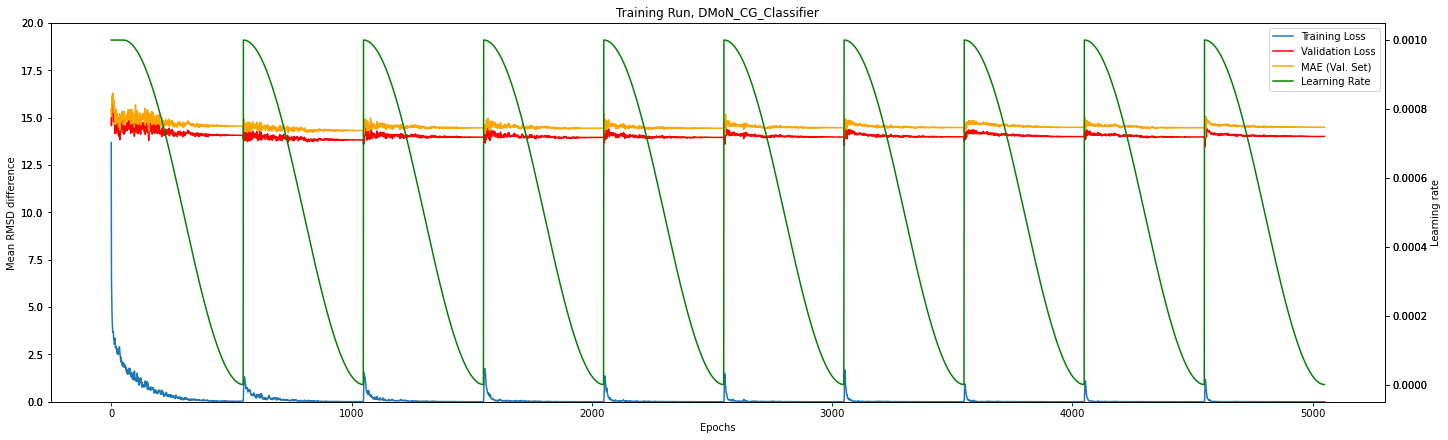

In [2]:
#Training
model = DMoN_CG_Classifier(training_dataset.num_node_features)

parent_dir = "pyg_model_data/"


epoch_losses, val_losses, mae_losses, learning_rates = pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5000,
    sched_T0=500,
    vectorize=vectorize,
    k=k,
    burn_in=50)

In [4]:
#get training run data

file = "pyg_model_data/2022-04-29_15-25_DMoN_CG_Classifier/loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.0008 in epoch 5012
Minimum Validation Loss (after 50 epochs) 13.4627 in epoch 4553
Minimum MAE (after 50 epochs) 13.9562 in epoch 4553


Validation Loss at 4310 is 13.9271
5 before select
14.0166, 13.9825, 13.9757, 13.9727, 13.9680
5 after select
13.9679, 13.9382, 14.0230, 13.9799, 13.9931
MAE at 4310 is 14.4160


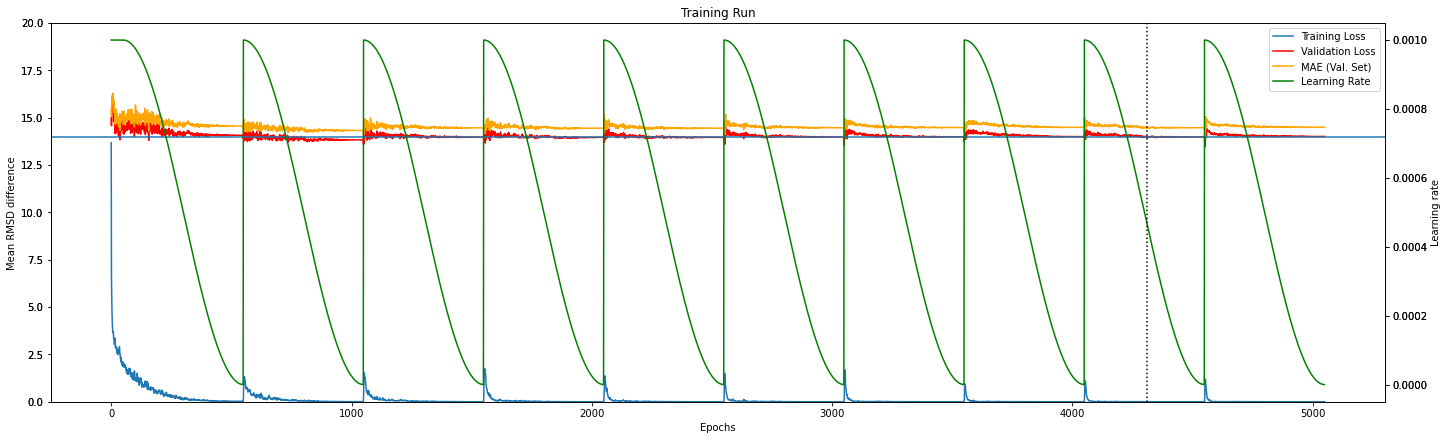

In [11]:
#plot the training run
select = 4310
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=14)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

Test Set
tensor([[16.8360]], device='cuda:0') tensor([[16.7230]], device='cuda:0') 0.006385676097124815
tensor([[0.8580]], device='cuda:0') tensor([[26.0266]], device='cuda:0') 24.66862678527832
Mean Test loss: 	 11.4138
Std. Dev. of Test loss:  6.9334
Min loss: 		 0.0064
First Quantile: 	 5.5390
Median: 		 10.5810
Third Quantile: 	 16.9566
Max Loss: 		 24.6686
LinregressResult(slope=-0.016143904994545977, intercept=17.146803391873636, rvalue=-0.005182882100843598, pvalue=0.9315690810877095, stderr=0.18783005399335637, intercept_stderr=3.9411028091103204)


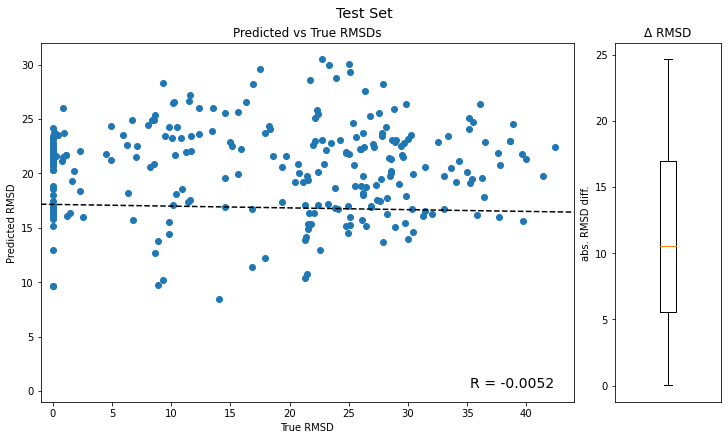

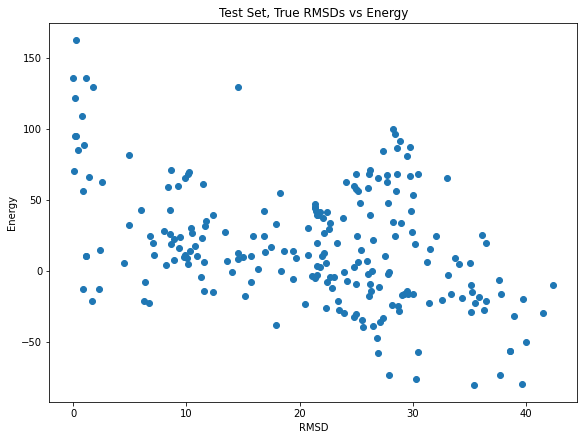

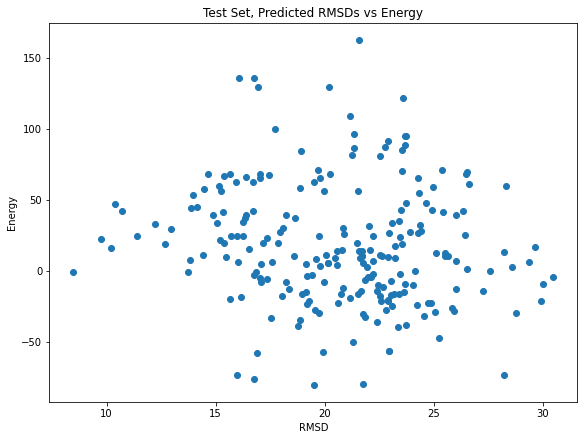

5S and tRNA Test Set
tensor([[22.9910]], device='cuda:0') tensor([[22.9677]], device='cuda:0') 0.0002709159452933818
tensor([[0.]], device='cuda:0') tensor([[29.5217]], device='cuda:0') 29.021696090698242
Mean Test loss: 	 4.2150
Std. Dev. of Test loss:  4.8912
Min loss: 		 0.0003
First Quantile: 	 1.0247
Median: 		 2.5074
Third Quantile: 	 5.7335
Max Loss: 		 29.0217
LinregressResult(slope=0.8332036307695042, intercept=1.0224873867893773, rvalue=0.6986853367443671, pvalue=2.1218899347803937e-159, stderr=0.025949158591989513, intercept_stderr=0.5022146283702376)


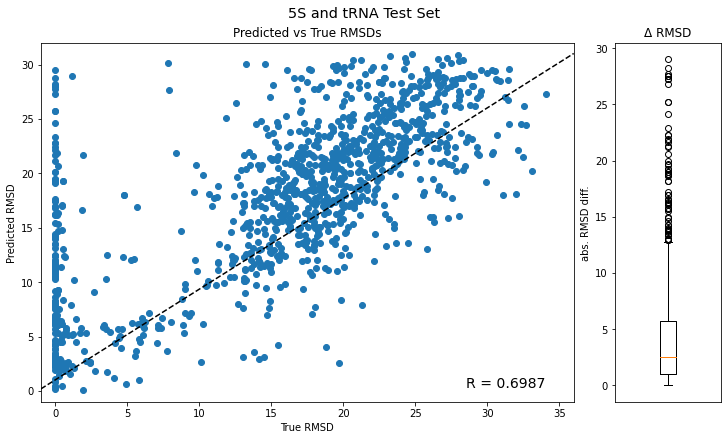

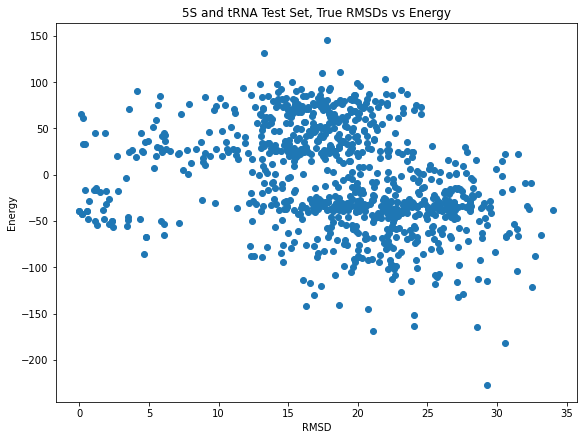

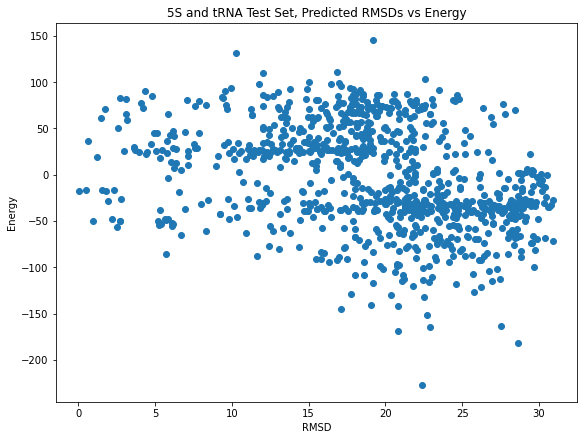

Training Set
tensor([[0.]], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([[34.3170]], device='cuda:0') tensor([[24.2400]], device='cuda:0') 9.576963424682617
Mean Test loss: 	 0.3545
Std. Dev. of Test loss:  0.8573
Min loss: 		 0.0000
First Quantile: 	 0.0085
Median: 		 0.0609
Third Quantile: 	 0.2836
Max Loss: 		 9.5770
LinregressResult(slope=1.0324033494807783, intercept=-0.4316677858324809, rvalue=0.9928018710124217, pvalue=0.0, stderr=0.0045237030488764875, intercept_stderr=0.08969812891167801)


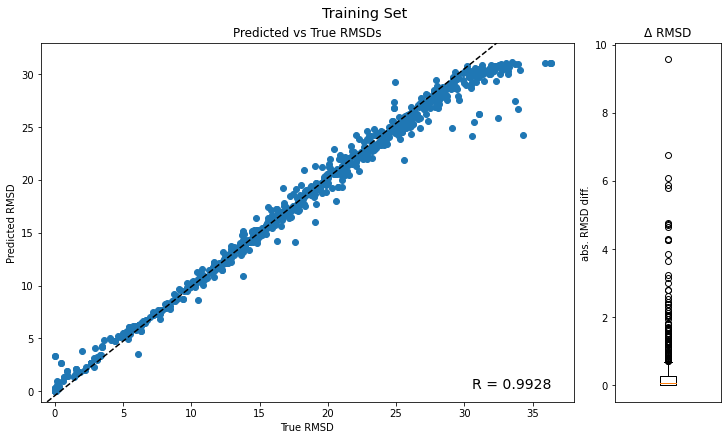

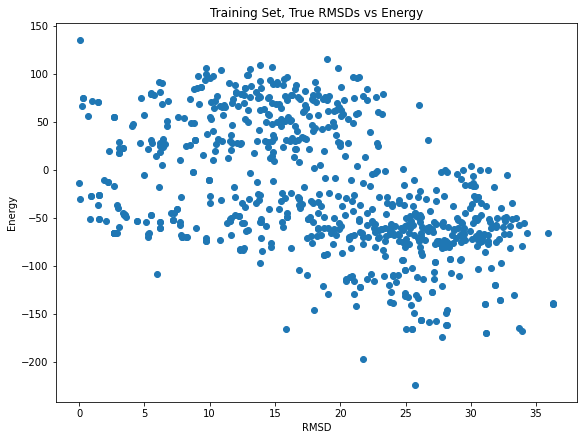

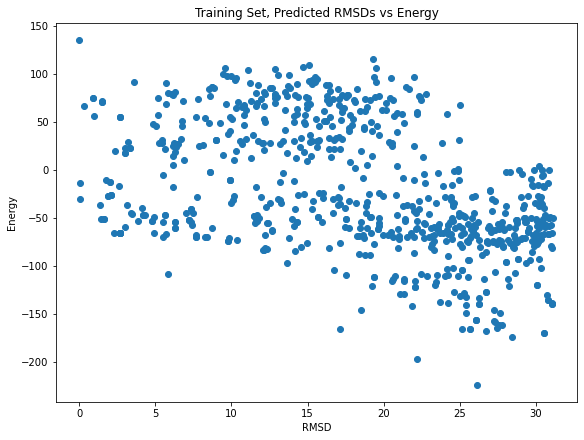

Validation Set
tensor([[11.0450]], device='cuda:0') tensor([[11.2335]], device='cuda:0') 0.017763325944542885
tensor([[60.4900]], device='cuda:0') tensor([[15.1630]], device='cuda:0') 44.826995849609375
Mean Test loss: 	 13.5164
Std. Dev. of Test loss:  9.3096
Min loss: 		 0.0178
First Quantile: 	 5.4636
Median: 		 13.2102
Third Quantile: 	 19.8449
Max Loss: 		 44.8270
LinregressResult(slope=-0.12803575983524715, intercept=25.895305237430676, rvalue=-0.03127757045950105, pvalue=0.5348627781428075, stderr=0.2061283016368542, intercept_stderr=4.342191235589793)


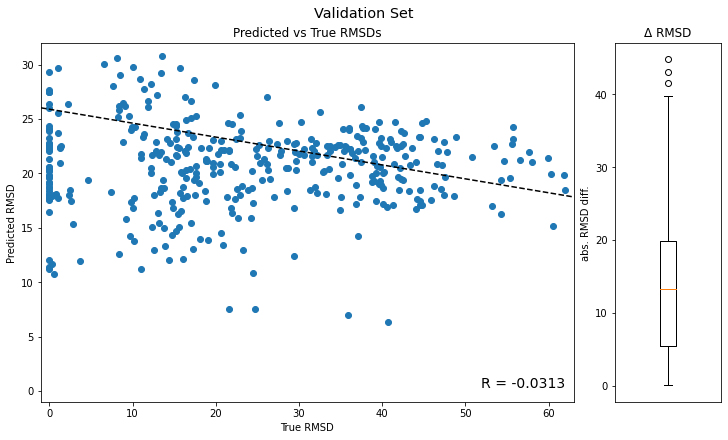

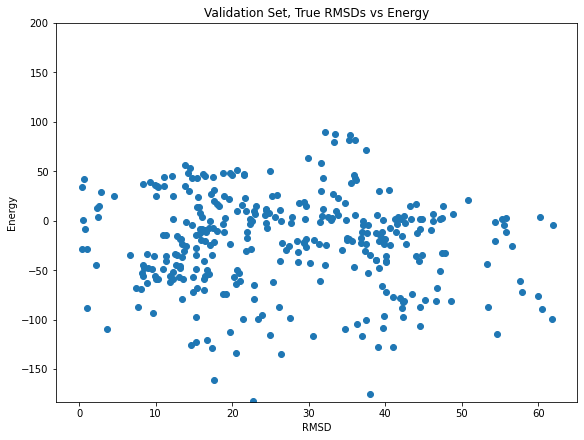

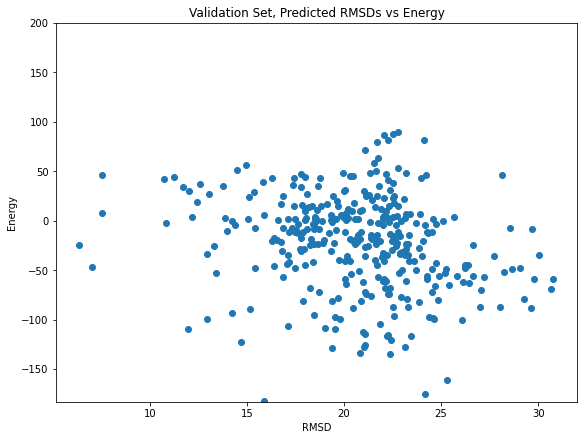

LinregressResult(slope=0.5967013338036313, intercept=9.053853983741066, rvalue=0.3477978094036965, pvalue=1.2167809736258758e-43, stderr=0.04168562498044734, intercept_stderr=0.8578655456127171)


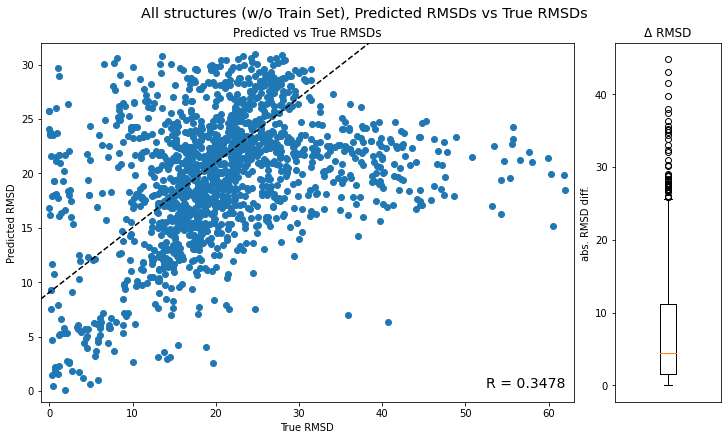

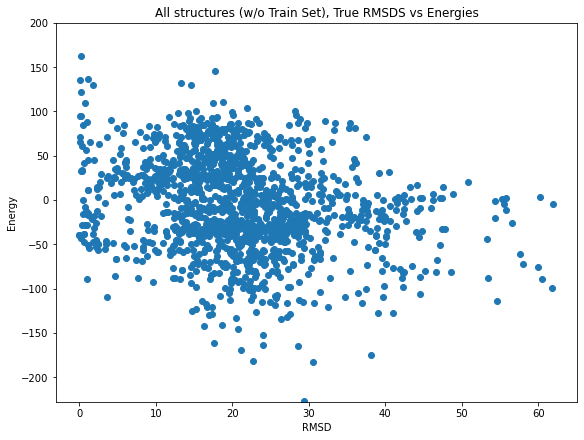

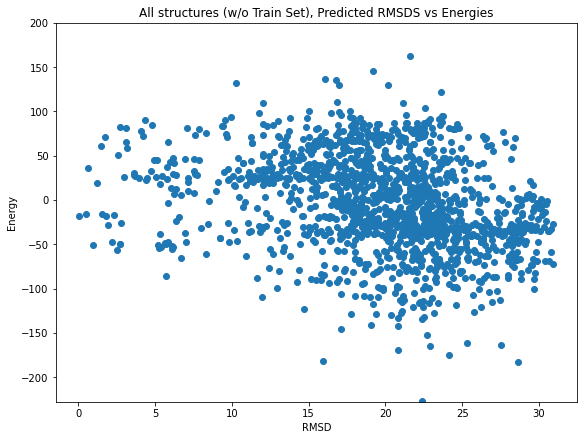

In [12]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = DMoN_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load("pyg_model_data/2022-04-29_15-25_DMoN_CG_Classifier/model_data/epoch_4310.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9954517649970078, intercept=0.13991808182537113, rvalue=0.9778662915242382, pvalue=7.303918410381832e-189, stderr=0.01284398990787058, intercept_stderr=0.2889148764204044)


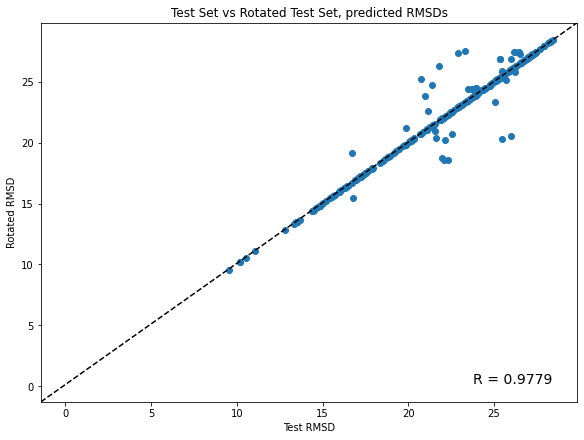

LinregressResult(slope=1.0044449797689865, intercept=-0.01411878808784195, rvalue=0.9939104832197659, pvalue=1.880093725433298e-265, stderr=0.006715166393131377, intercept_stderr=0.09763440692293635)


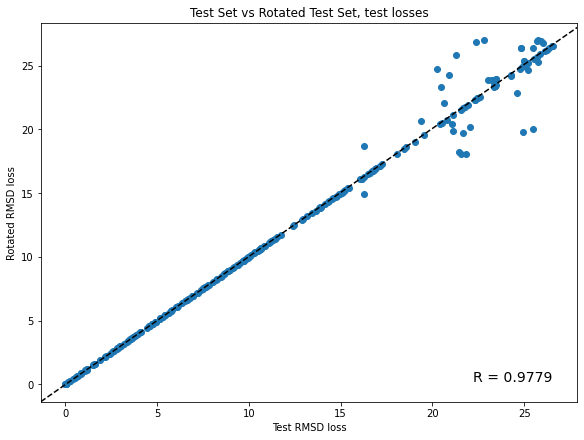

LinregressResult(slope=0.9796093591325599, intercept=0.35618392640965624, rvalue=0.9774875209875805, pvalue=0.0, stderr=0.006431279634000607, intercept_stderr=0.12576276784802848)


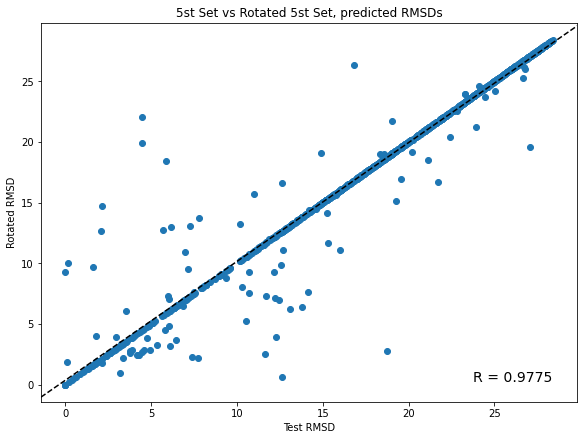

LinregressResult(slope=0.9451372804945786, intercept=0.21554724915183066, rvalue=0.9468924245439663, pvalue=0.0, stderr=0.009761816059501409, intercept_stderr=0.06239224492297283)


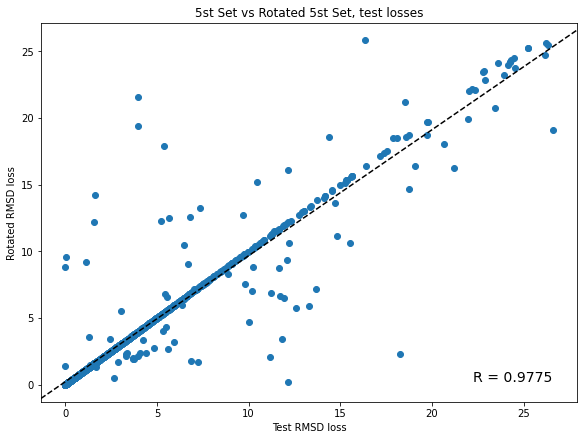

In [18]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")